In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data/14-global_active_power.csv')

print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2049280, 7)


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.216,2006,4,12,16,0
1,2006-12-16 17:25:00,5.360,2006,4,12,16,0
2,2006-12-16 17:26:00,5.374,2006,4,12,16,0
3,2006-12-16 17:27:00,5.388,2006,4,12,16,0
4,2006-12-16 17:28:00,3.666,2006,4,12,16,0


## Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

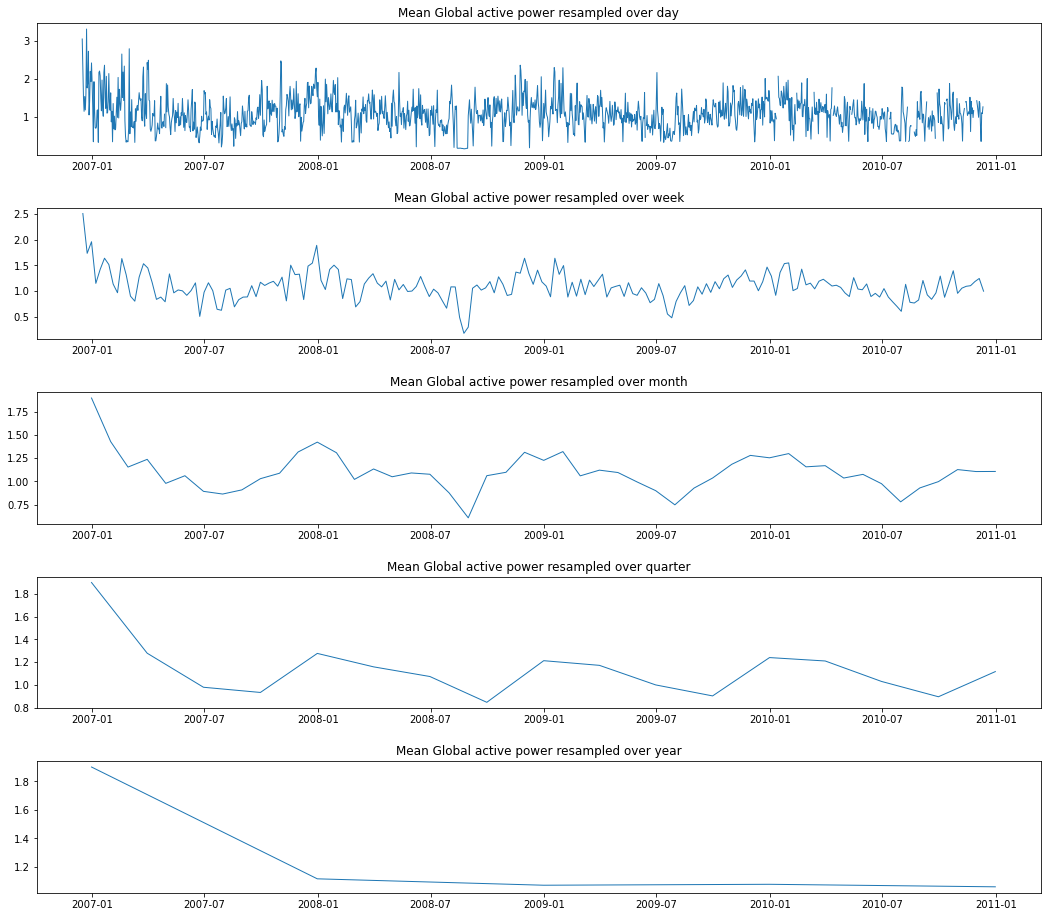

In [3]:
df1 = df.loc[:,['date_time','Global_active_power']]
df1['date_time'] = pd.to_datetime(df['date_time'])
df1.set_index('date_time', inplace=True)

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major')

## Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [4]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

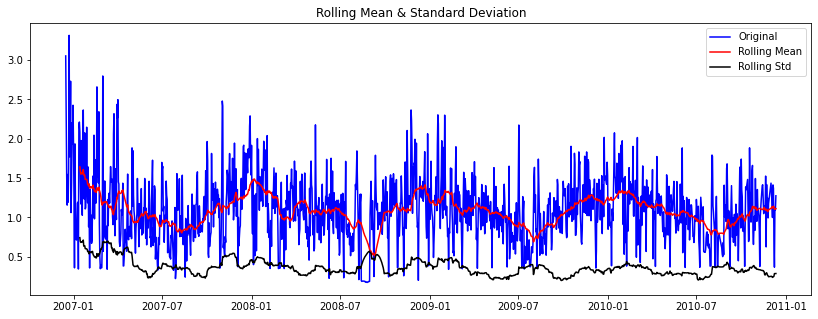


Test Statistic                -8.327686e+00
p-value                        3.435135e-13
#Lags Used                     9.000000e+00
Number of Observations Used    1.423000e+03
Critical Value (1%)           -3.434954e+00
Critical Value (5%)           -2.863573e+00
Critical Value (10%)          -2.567852e+00
dtype: float64


In [5]:
df2 = df1.resample('D').mean()

test_stationarity(df2.Global_active_power.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [6]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [9]:
X_train.shape

(1639393, 30)

In [10]:
Y_train.shape

(1639393,)

In [11]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Model Architecture

In [12]:
X_train.shape

(1639393, 1, 30)

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/20
23420/23420 [==============================] - 71s 3ms/step - loss: 7.7591e-04 - val_loss: 4.1786e-04
Epoch 2/20
23420/23420 [==============================] - 68s 3ms/step - loss: 6.6457e-04 - val_loss: 4.6002e-04
Epoch 3/20
23420/23420 [==============================] - 75s 3ms/step - loss: 6.5364e-04 - val_loss: 4.4918e-04
Epoch 4/20
23420/23420 [==============================] - 74s 3ms/step - loss: 6.4789e-04 - val_loss: 4.5986e-04
Epoch 5/20
23420/23420 [==============================] - 78s 3ms/step - loss: 6.4350e-04 - val_loss: 4.4210e-04
Epoch 6/20
23420/23420 [==============================] - 77s 3ms/step - loss: 6.4049e-04 - val_loss: 4.2608e-04
Epoch 7/20
23420/23420 [==============================] - 80s 3ms/step - loss: 6.3753e-04 - val_loss: 4.2984e-04
Epoch 8/20
23420/23420 [==============================] - 91s 4ms/step - loss: 6.3473e-04 - val_loss: 4.3795e-04
Epoch 9/20
23420/23420 [==============================] - 84s 4ms/step - loss: 6.3243e-04 - val_

In [14]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], 
                                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], 
                                                                  train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], 
                                                                 test_predict[:,0])))

12808/12808 [==============================] - 22s 2ms/step
Train Mean Absolute Error: 0.11553166546196479
Train Root Mean Squared Error: 0.2679688510230397
Test Mean Absolute Error: 0.10144080069733871
Test Root Mean Squared Error: 0.22229736223777646


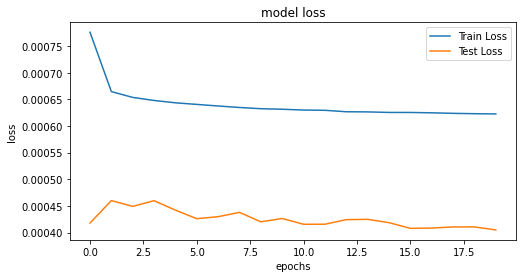

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

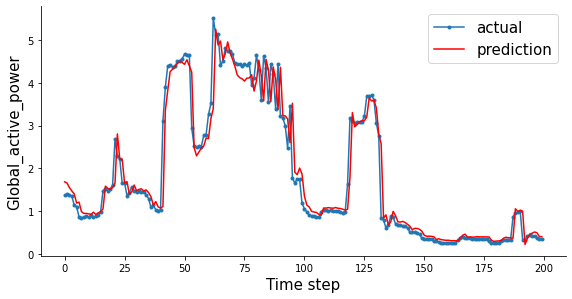

In [16]:
aa = [x for x in range(200)]

plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();